# Evaluation of MobileNet V2 using CIFAR-10
In this notebook we will go through some key evaluation metrics for CNNs in order to analyze how efficiently and accurately the MobileNet-V2 model predicts on the CIFAR-10 dataset.

## Setup

In [ ]:
import os, time, torch
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

from model import TransferModel
from data_preparation.CIFAR_10.data_cifar_10 import test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

 19%|█▊        | 31653888/170498071 [00:15<00:23, 5882116.78it/s]

Defining specific variables for the evaluation script:

In [7]:
model_name = 'MobileNet V2'
dataset_name = 'CIFAR-10'
class_labels = test_loader.dataset.classes
class_labels[:8]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse']

Import the data for evaluation, taken from the training step.

In [8]:
full_history = pd.read_csv(
    '../data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_cifar10_full_best_training_history.csv')
full_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [9]:
head_history = pd.read_csv(
    '../data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_cifar10_head_best_training_history.csv')
head_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [10]:
lastblock_history = pd.read_csv(
    '../data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_cifar10_lastblock_best_training_history.csv')
lastblock_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [11]:
test_loss = pd.read_csv('../data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_test_loss_list.csv')
test_loss.columns

Index(['batch_loss'], dtype='object')

In [12]:
test_pred = pd.read_csv('../data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_test_predictions.csv')
y_true = test_pred.True_Label
y_pred = test_pred.Predicted_Label
test_pred.columns

Index(['True_Label', 'Predicted_Label'], dtype='object')

In [13]:
model_path = '../data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_cifar10_full_best.pth'

## Visualization of Model Predictions

Creating instance of our model:

In [14]:
model = TransferModel(num_classes=10, backbone='mobilenet_v2', pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

This function visualizes the model predictions (with True and Predicted labels).

In [15]:
def visualize_model_predictions(model, loader, class_labels, target_class=None, num_images=5, device="cpu"):
    samples = [] 
    
    if target_class is not None: 
        target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    plt.figure(figsize=(15, 4))
    
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    for i in range(len(samples)):
        ax = plt.subplot(1, num_images, i + 1)
        
        img_tensor, true_id, pred_id = samples[i]
        img = img_tensor.permute((1, 2, 0)).numpy() 
        
        # Denormalization step
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean # (img - mean) / std
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        
        true_label = class_labels[true_id]
        pred_label = class_labels[pred_id]
        
        # Green for correct, Red for wrong
        color = 'green' if true_id == pred_id else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.show()

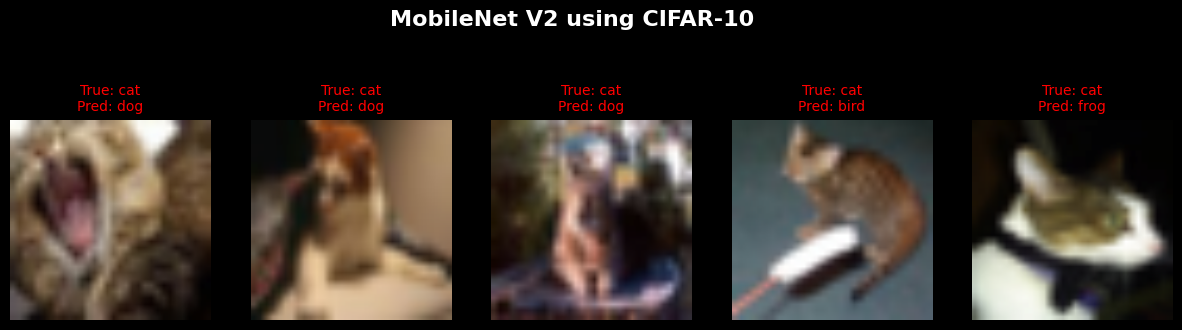

In [17]:
visualize_model_predictions(model, test_loader, class_labels, target_class='cat', num_images=5, device=device)

## Training Dynamics
### Stability & Overfitting Check
In this section we will compare how well the model was trained during the 3 different transfer learning strategies:
* **Full fine-tuning (full)** -> Training all layers of the network.
* **Linear probing (head)** -> Training only the final classification head while keeping the backbone frozen.
* **Partial fine-tuning (last)** -> Unfreezing the final blocks of the MobileNet architecture to allow for feature adaptation.

In [18]:
# define a dictionary to store for each strategy -> name(key), df, color
strategies = {
    "Head Only": {"df": head_history, "color": "#e57373"},
    "Last Block": {"df": lastblock_history, "color": "#ffb74d"},
    "Full Tuning": {"df": full_history, "color": "#81c784"}
}

### Max Accuracy (Top-1 Accuracy)

This metric shows how often the model’s single most confident prediction is actually correct:
$$\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(\hat{y}_i = y_i)$$

Max accuracy

Head Only: 76.58%
Last Block: 87.74%
Full Tuning: 93.56%


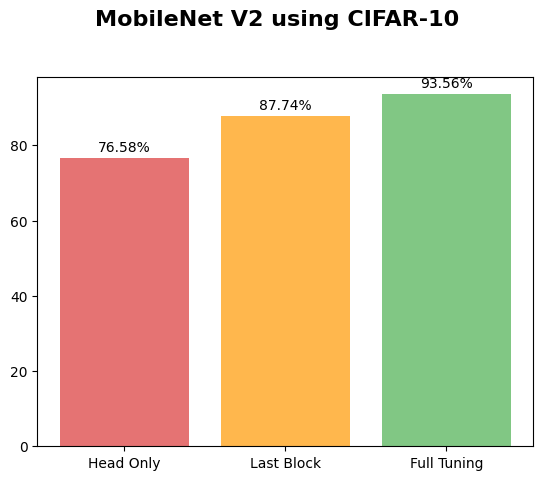

In [13]:
print("Max accuracy\n")

for key, item in strategies.items():
    item['maxAcc'] = item['df']['val_acc'].max() * 100
    print(f"{key}: {item['maxAcc']:.2f}%")

bars = plt.bar(strategies.keys(), [strategies[i]['maxAcc'] for i in strategies], color=[strategies[i]['color'] for i in strategies])
plt.bar_label(bars, padding=3, fmt='%.2f%%')
plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
pass

**Head Only results:** An accuracy of 76.58% indicates that the generic features learned from ImageNet are not fully aligned with the CIFAR-10 dataset. Therefore, freezing the entire feature extraction backbone is not the best strategy in this case.

<br>**Last Block results:** The accuracy increases by 11% compared to the head-only strategy. This indicates that high-level semantic features need to be adapted to better suit the 10 classes of CIFAR-10. By unfreezing the last block, the model bridges the gap between the pre-training dataset and the target dataset.

<br>**Full Tuning results:** Since the model can adjust all parameters, this approach yields the highest accuracy on CIFAR-10.

### Combined Validation Accuracy
With this metric we can compare the learning capabilities of the training strategies for our model.

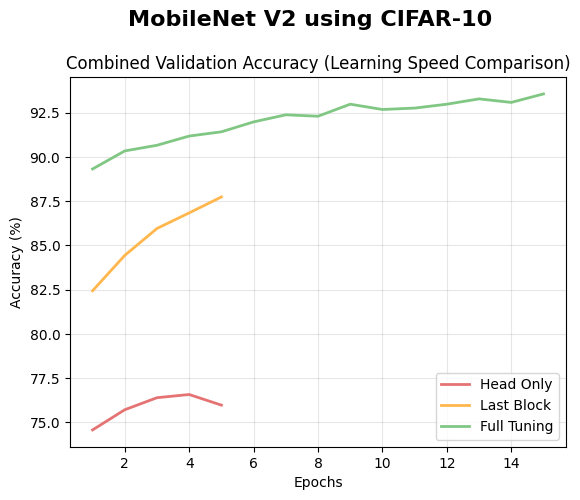

In [14]:
for key, item in strategies.items():
    df = item['df']
    epochs = range(1, len(df) + 1)
    plt.plot(epochs, df['val_acc'] * 100, label=key, color=item['color'], linewidth=2)

plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
plt.title('Combined Validation Accuracy (Learning Speed Comparison)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Head Only Strategy**
This strategy results in the lowest accuracy ~76% -> the model cannot adapt deep features to the new data.

<br>**Last Block Strategy**
In this strategy, only the final convolutional block is unfrozen, allowing the model to learn more dataset-specific features.

<br>**FUll Tuning Strategy**
Unfreezing all layers allows the model to gradually reach the highest performance (>93%), as this strategy fully adapts the pretrained weights to CIFAR-10.

### Training Loss vs Validation Loss

These graphs will show us how well the model generalizes to unseen data, depending on which training strategy was used.

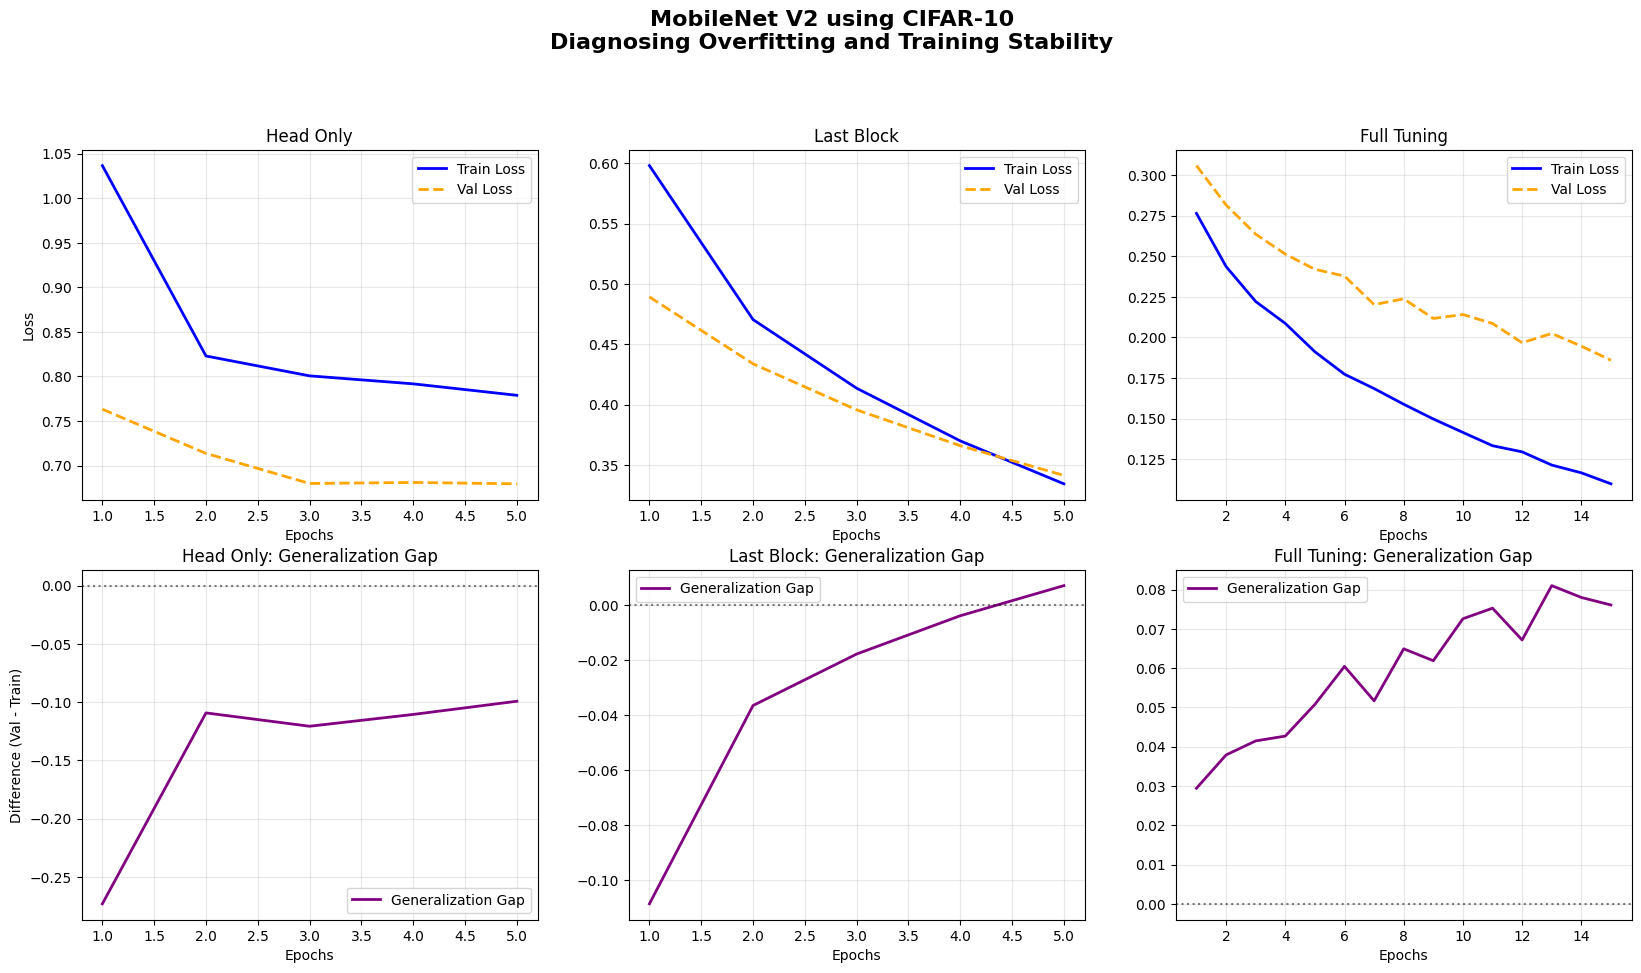

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, (key, item) in zip(axes[0], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)
    
    #Training Loss
    ax.plot(epochs, df['train_loss'], label='Train Loss', color='blue', linewidth=2)
    
    #Validation Loss
    ax.plot(epochs, df['val_loss'], label='Val Loss', color='orange', linestyle='--', linewidth=2)
    
    ax.set_title(f'{key}', )
    ax.set_xlabel('Epochs')

    if key == "Head Only":  ax.set_ylabel('Loss')

    ax.legend()
    ax.grid(True, alpha=0.3)

#plotting Generalisation Gap Metric
for ax, (key, item) in zip(axes[1], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)

    # Calculate gap
    df['gap'] = df['val_loss'] - df['train_loss']
    
    ax.plot(epochs, df['gap'], label='Generalization Gap', color='purple', linewidth=2)
    ax.axhline(y=0, color='black', linestyle=':', alpha=0.5)
    
    ax.set_title(f'{key}: Generalization Gap')
    ax.set_xlabel('Epochs')

    if key == "Head Only": ax.set_ylabel('Difference (Val - Train)')
    
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{model_name} using {dataset_name}\nDiagnosing Overfitting and Training Stability', fontsize=16, weight='bold', y=1.02)
plt.show()

**Head Only:**
- Loss curves: The validation loss remains consistently lower than the training loss, indicating that the frozen feature extractor struggles to fit the training data.
- Generalization gap: Negative (validation performance exceeds training performance).
> Interpretation: Underfitting (high bias) - the model fails to adequately learn even the training data because the feature extractor is frozen and cannot adapt to CIFAR-10.

<br>**Last Block:**
- Loss curve: The training loss starts higher but decreases faster, crossing the validation loss curve at the final epoch (epoch 5)
- Generalization gap: increases from negative and crosses zero at epoch 5
> Balanced -> the generalization gap indicates a point where the model capacity matches the data complexity (around epoch 5)

<br>**Full Model:**
- Loss curve: The validation loss curve remains significantly higher than the training loss curve throughout the entire training process.
* Generalization gap: increases and stays positive
> **Small overfitting** -> high variance -> the generalisation gap (purple curve) indicates that the model begins to memorize the training data. However, the high accuracy (93.56%) shows that a small amount of overfitting is acceptable to achieve the highest performance

## High-Level Performance 
### Global Metrics Comparison
The aim of this section is to analyze the model accuracy, precision and f1-score from the best training strategy (by generating theirs distributions).

Function to plot distribution of metrics:

In [16]:
def print_distribution(df_report, metric:str):
    scores = (df_report[metric] * 100).copy()

    #we drop the global metrics so we only analyze the specific classes (apple, bear, etc.)
    summary_rows = ['accuracy', 'macro avg', 'weighted avg']
    class_scores = scores.drop(summary_rows, errors='ignore')

    # Kernel Density Estimate (KDE) line
    sns.histplot(class_scores, kde=True, bins=15, edgecolor='white', color='#4c72b0')

    # mean performance
    mean_val = class_scores.mean()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean {metric}: {mean_val:.1f}%')

    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.title(f'Distribution of {metric} Per Class', fontsize=14, weight='bold')
    plt.xlabel(f'{metric} (%)', fontsize=12)
    plt.ylabel('Number of Classes', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Global characteristics:

In [17]:
# generate a report for all 100 classes
report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels, 
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()
df_report.head(5)

,precision,recall,f1-score,support
airplane,0.943888,0.942,0.942943,1000.0
automobile,0.965760,0.959,0.962368,1000.0
bird,0.957292,0.919,0.937755,1000.0
cat,0.853000,0.853,0.853000,1000.0
deer,0.924303,0.928,0.926148,1000.0


To get main performance metrics `classification_report` was used.

In [18]:
report = classification_report(y_true, y_pred, output_dict=True)

print(f"Global Accuracy:    {report['accuracy'] * 100:.2f}%")
print(f"Macro Precision:    {report['macro avg']['precision'] * 100:.2f}%")
print(f"Weighted Precision: {report['weighted avg']['precision'] * 100:.2f}%")
print(f"Macro F1-Score:     {report['macro avg']['f1-score'] * 100:.2f}%")

Global Accuracy:    93.23%
Macro Precision:    93.27%
Weighted Precision: 93.27%
Macro F1-Score:     93.24%


### Precision
This metric shows the quality of the model’s predictions. High precision means that when the model predicts a class, it is usually correct. Low precision indicates that the model produces many incorrect positive predictions, resulting in a high number of false positives.

$$Precision = \frac{TP}{TP + FP}$$
Out of all the samples the model predicted as positive, how many were actually positive?

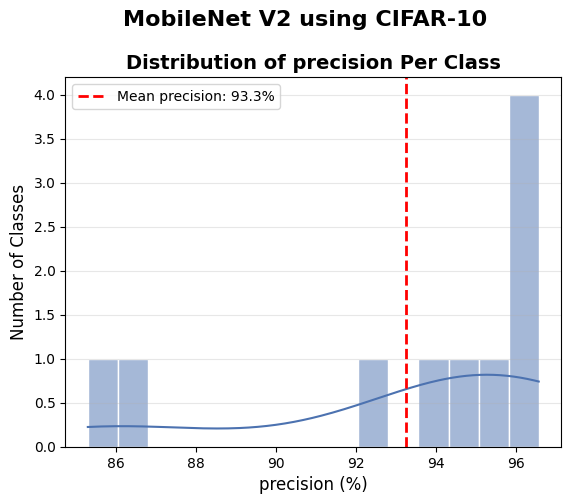

In [19]:
print_distribution(df_report,'precision')

The histogram shows that the model performs exceptionally well for the majority of categories, achieving a mean precision of 93.3% with nearly half of the classes scoring above 96%.

<br>But the distribution also has a performance gap, as two specific classes are significantly harder for the model to identify.

### Recall
This metric measures the "completeness" of our model's predictions. It is defined below:

$$Recall = \frac{TP}{TP + FN}$$

> Out of all images that actually belong to a given class, how many did the model correctly identify?

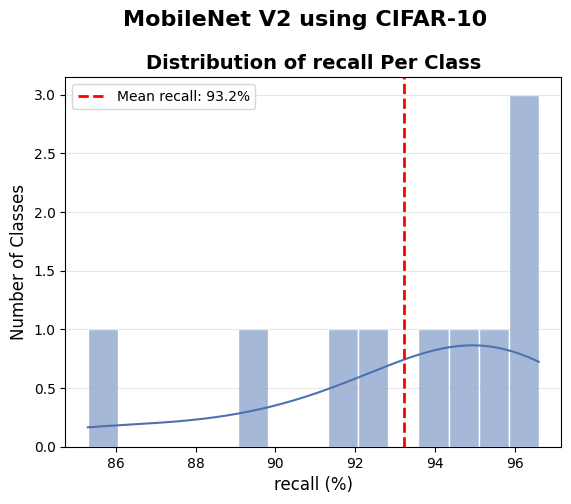

In [20]:
print_distribution(df_report,'recall')

The model achieves a strong mean recall of 93.2%, with a dominant cluster of three classes reaching near-perfect sensitivity above 96%. But we can also notice that the performance is not uniform, since the distribution is left-skewed, where specific outlier classes struggle with recall scores as low as ~86%.

### F1-Score
$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
> How well does the model balance correctly identifying all relevant images (recall) while minimizing incorrect predictions (precision)?

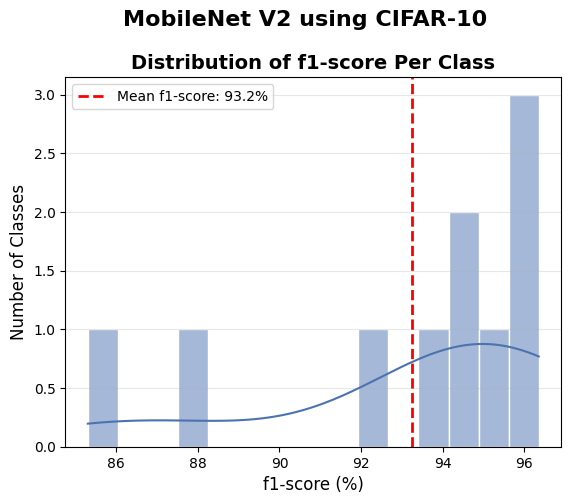

In [21]:
print_distribution(df_report,'f1-score')

The F1-score distribution highlights the model's robust balance between precision and recall (averaging 93.2%), where most classes cluster near a top-tier score of ~96%, though a few persistent outliers in the 85–88% range pull the overall average down.

## Class Level Analytics
### Confusion Matrix
Using the confusion matrix, we can analyze model performance beyond a single score (e.g., accuracy) and directly observe where and how classification errors occur.

<br>For CIFAR-100, we first generate 100 binary (2×2) confusion matrices, one for each class, to analyze class-wise prediction behavior. We then visualize the full confusion matrix as a heatmap, which allows us to identify the top 10 most frequently confused classes.

Binary confusion matrix:
$$\begin{bmatrix}
\text{True Negatives (TN)} & \text{False Positives (FP)} \\
\text{False Negatives (FN)} & \text{True Positives (TP)}
\end{bmatrix}$$

In [22]:
# convert numeric class indices to class name labels
y_true_classes = [class_labels[i] for i in y_true]
y_pred_classes = [class_labels[i] for i in y_pred]

# calculates confusion matrix for each class
overall_confusion_matrix = confusion_matrix(y_true, y_pred)
per_class_confusion_matrices = multilabel_confusion_matrix(y_true_classes, y_pred_classes, labels=class_labels)

n = 3
print(f'Confusion matrices for {n} classes\n')
for i in range(n):
    print(f'{class_labels[i]}')
    print(per_class_confusion_matrices[i],'\n')

Confusion matrices for 3 classes

airplane
[[8944   56]
 [  58  942]] 

automobile
[[8966   34]
 [  41  959]] 

bird
[[8959   41]
 [  81  919]] 



To better interpret the confusion matrices, we analyze a representative example.

In [23]:
def print_analytics_of_conf_matrix(cm, target_class):
    target_class_id = class_labels.index(target_class) if type(target_class)==str else target_class
    target_class_name = target_class if type(target_class)==str else target_class

    target_cm = cm[target_class_id]

    print(f'Confusion matrix for {target_class_name}')
    print(target_cm)
    
    indices = [i for i, x in enumerate(y_true) if x == target_class_id] # actual label
    predictions_for_target = [y_pred[i] for i in indices] # predicts

    counts = Counter(predictions_for_target) # count

    print(f"\nWhen the image was '{target_class_name}', the model predicted:")
    for pred_id, count in counts.most_common(5):
        print(f" - {class_labels[pred_id]}: {count} times")

In [24]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'airplane')

Confusion matrix for airplane
[[8944   56]
 [  58  942]]

When image was actually 'airplane', but the model predicted:
 - airplane: 942 times
 - ship: 21 times
 - truck: 9 times
 - bird: 7 times
 - deer: 7 times


The confusion matrix plot shows true class labels along the rows and predicted class labels along the columns. The diagonal represents correct predictions, while all off-diagonal cells correspond to misclassifications.

In [25]:
def conf_matrix_heatmap(cm, model_name, data_name, dots_to_plot:list[list[int]]=None, class_labels=None):
    sns.heatmap(cm, 
                annot=False, # if true numbers will appear
                cmap='Blues', # color 'Blues' or 'viridis' 
                vmax=20,
                cbar_kws={'label': 'Number of Images'}
                )           
    if dots_to_plot:
        x_coords = []
        y_coords = []

        for true_id, pred_id in dots_to_plot:
            x_coords.append(pred_id + 0.5)  # -> to be in middle of square
            y_coords.append(true_id + 0.5)
            
            print(f"Marking: {class_labels[true_id]} (ID {true_id}) -> {class_labels[pred_id]} (ID {pred_id})")
    
        plt.scatter(x_coords, y_coords, color='red', marker='o', linewidth=2)
    
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.xlabel('Predicted Class ID')
    plt.ylabel('True Class ID')
    plt.show()

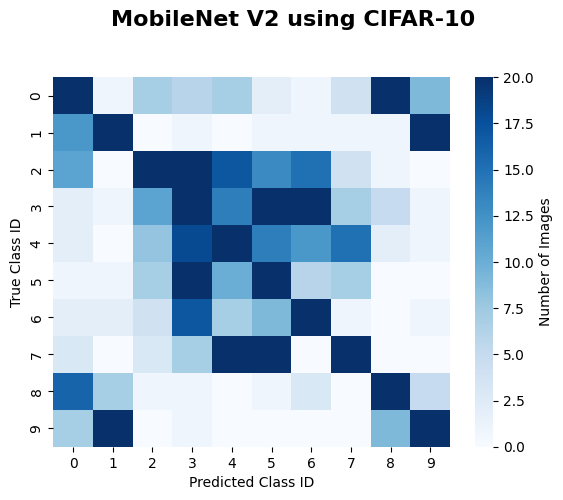

In [26]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name)

How can we use confusion matrix?

In [27]:
def get_top_confusions(y_true, y_pred, class_names, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0) # Zero out correct predictions (diagonal) to find errors
    
    pairs = []
    for i in range(10):
        for j in range(10):
            if cm[i, j] > 0:
                pairs.append((i, j, cm[i, j]))
    
    # Sort in descending order
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f">>> Top {top_n} Confusions <<<")
    for i in range(min(top_n, len(pairs))):
        true_idx, pred_idx, count = pairs[i]
        
        t_name = class_names[true_idx] if class_names else str(true_idx)
        p_name = class_names[pred_idx] if class_names else str(pred_idx)
        
        print(f"True: {class_labels.index(t_name)} - {t_name:<15} Predicted: {class_labels.index(p_name)} - {p_name:<15} Count: {count}")
        
get_top_confusions(y_true,y_pred,class_labels)

>>> Top 10 Confusions <<<
True: 3 - cat             Predicted: 5 - dog             Count: 80
True: 5 - dog             Predicted: 3 - cat             Count: 76
True: 3 - cat             Predicted: 6 - frog            Count: 26
True: 1 - automobile      Predicted: 9 - truck           Count: 24
True: 9 - truck           Predicted: 1 - automobile      Count: 22
True: 0 - airplane        Predicted: 8 - ship            Count: 21
True: 7 - horse           Predicted: 4 - deer            Count: 21
True: 2 - bird            Predicted: 3 - cat             Count: 20
True: 7 - horse           Predicted: 5 - dog             Count: 20
True: 4 - deer            Predicted: 3 - cat             Count: 18


We can see that the model has problems with the pair cat <-> dog. Let's examine it.

Marking: cat (ID 3) -> dog (ID 5)
Marking: dog (ID 5) -> cat (ID 3)


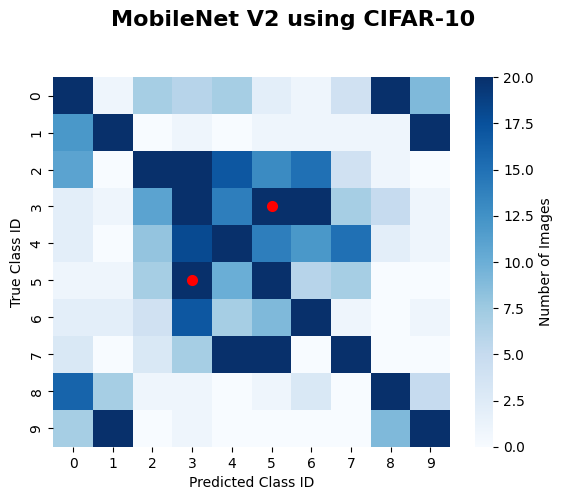

In [31]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name, dots_to_plot=[[3,5], [5,3]], class_labels=class_labels)

In [32]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'cat')

Confusion matrix for cat
[[8853  147]
 [ 147  853]]

When image was actually 'cat', but the model predicted:
 - cat: 853 times
 - dog: 80 times
 - frog: 26 times
 - deer: 14 times
 - bird: 11 times


We can also see this on the actual data:

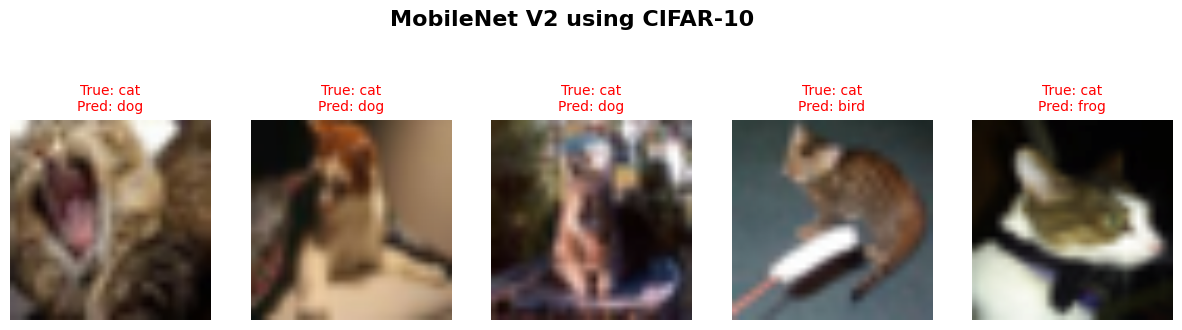

In [29]:
visualize_model_predictions(model,test_loader,class_labels,'cat')

## Efficiency Analytics
The main objective of this section is to analyze the model’s efficiency in terms of disk storage requirements, the total number of parameters, and the forward pass execution time (i.e., the time elapsed from when an input tensor enters the first layer until the output probability vector is produced by the final layer).

In [ ]:
def get_efficiency_metrics(model, loader, device, model_path):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total number of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples

    print(f">>> Global Efficiency & Confidence Metrics")
    print(f"Model Size:       {size_mb:.2f} MB")
    print(f"Total Params:     {params:,}")
    print(f"Inference Time:   {avg_inference_time*1000:.2f} ms per image")
  
    return size_mb, params, avg_inference_time
#get_efficiency_metrics(model, test_loader, device, model_path)

## Conclusions

### Training Strategy
The results strongly favor **Full Fine-Tuning** as the optimal strategy for adapting MobileNet V2 to CIFAR-10.
* **Head Only (76.58%)**: Yielded the lowest performance, indicating that the frozen ImageNet features were insufficient for the specific nuances of CIFAR-10 data.
* **Last Block (~87%)**: Unfreezing just the final block provided a significant jump (~11%) over the Head Only approach, proving that adapting high-level semantic features is crucial.
* **Full Tuning (93.56%)**: Achieved the best results. By allowing the entire network (from low-level edges to high-level shapes) to adapt, the model maximized its accuracy. This highlights how strongly the model benefits from deep adaptation.

### Model Reliability & Balance
The model demonstrates high reliability with **Precision, Recall, and F1-Score all averaging ~93%**.
The performance distribution is largely uniform, with nearly half of the classes achieving near-perfect scores (>96%). However, the distribution is slightly left-skewed, revealing a small cluster of "outlier" classes (scoring ~86-88%) that prevent the model from achieving a perfect score across the board.

### Error Analysis
The confusion matrix highlights that the errors are predictable and consistent with visual similarity:
* **Cat ↔ Dog**: This remains the most significant source of confusion, likely due to shared features like fur texture and ear shape.
* **Frog ↔ Cat**: A notable secondary confusion, possibly due to the small, crouching shapes often found in CIFAR-10 images.
* **Deer ↔ Horse**: Occasional confusion occurs here, driven by similar body structures and backgrounds.

### Efficiency
MobileNet V2 proves to be an extremely efficient architecture. With a very compact size and fast inference capabilities, it rivals ResNet-18 in performance while requiring fewer parameters (depending on the specific implementation details). It is an excellent candidate for mobile or edge-deployment scenarios where storage and speed are critical constraints.